In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from hindemith import hmarray
from hindemith.core import compose
from hindemith.operations.array import Square
from hindemith.operations.convolve import Convolve2D
import hindemith as hm
import cv2
from hmcaffe.demo.classify import classify
import numpy as np

def show_bgr_im(frame):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

Here's two frames from a video of my cat Arya.

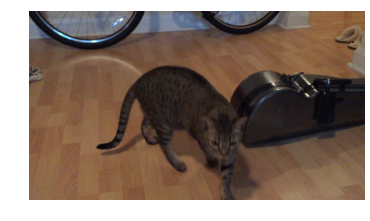

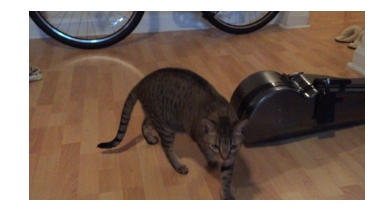

In [17]:
frame0 = cv2.imread('images/output-0099.png')
frame1 = cv2.imread('images/output-0100.png')

show_bgr_im(frame0)
show_bgr_im(frame1)

# Optical Flow

Let's implement an optical flow solver, in this example we'll use the Horn-Schunk Jacobi method.  More info can be found [here](http://en.wikipedia.org/wiki/Horn–Schunck_method)

In [10]:
alpha = 15

jacobi = np.array([
    [1.0/12.0, 1.0/6.0, 1.0/12.0],
    [1.0/6.0, 0.0, 1.0/6.0],
    [1.0/12.0, 1.0/6.0, 1.0/12.0]
])

dx = np.array([[-1.0/12.0, -2.0/3.0, 0.0, 2.0/3.0, 1.0/12.0]])
dy = np.array([[-1.0/12.0], [-2.0/3.0], [0.0], [2.0/3.0], [1.0/12.0]])

alpha2 = alpha ** 2
epsilon = .01

@compose
def hs_jacobi(im0, im1, u, v):
    It = im1 - im0
    Iy = Convolve2D(im1, dy)
    Ix = Convolve2D(im1, dx)
    denom = Square(Ix) + Square(Iy) + alpha2

    for _ in range(100):
        ubar = Convolve2D(u, jacobi)
        vbar = Convolve2D(v, jacobi)
        t = (Ix * ubar + Iy * vbar + It) / denom
        u_new = ubar - Ix * t
        v_new = vbar - Iy * t
        u, v = u_new, v_new
    return u, v

We'll run it on our two frames and display it using a common technique for visualizing optical flow.  We'll use the color wheel to specify direction (each angle has a corresponding hue) and intensity to indicate magnitude.

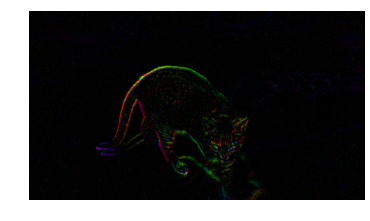

In [14]:
hsv = np.zeros_like(frame0)
im0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)
hm_u = hm.zeros_like(im0)
hm_v = hm.zeros_like(im0)
im1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)

hm_u, hm_v = hs_jacobi(im0, im1, hm_u, hm_v)

hm_u.sync_host()
hm_v.sync_host()
mag, ang = cv2.cartToPolar(hm_u, hm_v)
mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
ang = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 0] = ang
hsv[..., 2] = mag
flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
show_bgr_im(flow)

Now we'll write a relatively simple algorithm to draw a box around regions of interest.  In this case, we'll use the magnitude of motion vectors and apply a histogram based segmentation technique.  If you think of a horizontal histogram, we're interested in clustered peaks which would indicate a moving object.  After performing a horizontal histogram, we can repeat the process vertically for our columns of interest.  This technique is not the most robust for a few reasons.  It does not take into account direction of motion (this would allow us to segment occluded objects if they were moving in seperate direction), and it does not work well with occluded objects in general.  However, for the purposes of this demo and these frames, this works well enough. 

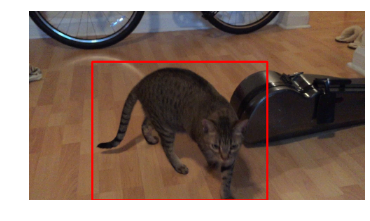

In [15]:
NOISE_THRESHOLD = 30
NOISE_GAIN = 0.1

BLACK_THRESHOLD = NOISE_THRESHOLD * 1.25
MIN_HEIGHT = 60

offset = 0
FIXED_OFFSET = 1

VERTICAL_TOLERANCE = 30



def get_boxes(mag, image=None):
    width = mag.shape[1]
    height = mag.shape[0]
    horiz_hist = []

    for y in range(height):
        horiz_hist.append(np.max(mag[y]))

    rows = []
    start = None
    for i, val in enumerate(horiz_hist):
        if val > NOISE_THRESHOLD:
            if start is None:
                # if len(rows) > 0 and i - rows[-1][1] < 5:
                #     start = rows.pop()[0]
                # else:
                start = i
                thresh = 5
        else:
            if start is not None:
                thresh -= 1
                if thresh == 0:
                    rows.append((start, i))
                    start = None
    if start is not None:
        rows.append((start, height))

    ret = []
    # print(horiz_hist)
    # print(rows)
    for row in rows:
        # ret.append((row[0], 0, row[1], 384))
        vert_hist = []
        for col in range(width):
            vert_hist.append(np.max(mag[row[0]:row[1], col]))

        start = None
        for i, val in enumerate(vert_hist):
            if val > NOISE_THRESHOLD:
                if start is None:
                    start = i
            else:
                if start is not None:
                    row_start = row[0]
                    row_end = row[1]
                    if row_end - row_start > 16 and i - start > 16:
                        for r in range(row[0], row[1]):
                            if np.max(mag[r, start:i]) < 30:
                                row_start += 1
                            else:
                                break
                        for r in reversed(range(row[0], row[1])):
                            if np.max(mag[r, start:i]) < 30:
                                row_end -= 1
                            else:
                                break
                        row_start = max(row_start - 5, 0)
                        row_end = min(row_end + 5, height)
                        start = max(start - 5, 0)
                        i = min(i + 5, width)
                        ret.append([row_start, start, row_end, i])
                    start = None
        if start is not None:
            row_start = row[0]
            row_end = row[1]
            if row_end - row_start > 16 and i - start > 16:
                for r in range(row[0], row[1]):
                    if np.max(mag[r, start:i]) < 30:
                        row_start += 1
                    else:
                        break
                for r in reversed(range(row[0], row[1])):
                    if np.max(mag[r, start:i]) < 30:
                        row_end -= 1
                    else:
                        break
                row_start = max(row_start - 5, 0)
                row_end = min(row_end + 5, height)
                start = max(start - 5, 0)
                i = min(i + 5, width)
                ret.append([row_start, start, row_end, i])

    if image is not None:
        for rect in ret:
            cv2.rectangle(image, (rect[1], rect[0]),
                          (rect[3], rect[2]), (0, 0, 255), 2)

    return ret


windowed = np.copy(frame1)
windows = get_boxes(mag, windowed)
show_bgr_im(windowed)

Finally, with a regions of interest, we can run these through our classifier to find out what the model thinks it is.

---------
['n02124075', 'Egyptian', 'cat']
['n02123045', 'tabby,', 'tabby', 'cat']
['n02123159', 'tiger', 'cat']
['n01873310', 'platypus,', 'duckbill,', 'duckbilled', 'platypus,', 'duck-billed', 'platypus,', 'Ornithorhynchus', 'anatinus']
['n01704323', 'triceratops']


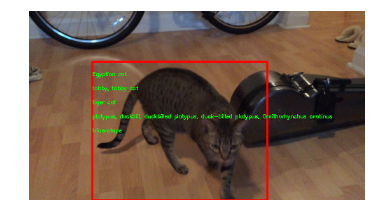

In [13]:
labeled = np.copy(windowed)
for window in windows:
    labels = classify(frame1[window[0]:window[2],
                             window[1]:window[3]])
    print("---------")
    for i, label in enumerate(reversed(labels)):
        label = label.split(" ")
        cv2.putText(labeled, " ".join(label[1:]), (window[1], window[0] + (i + 1) * 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 255, 0), 1)
        print(label)

show_bgr_im(labeled)